# Selection (Part 1: Features)

In [1]:
import shnitsel as st
database = st.io.read('./test_data/shnitsel/traj_I02.nc')
dataset = database['I02/0/data']
# dataset

Shnitsel tools contain a versatile selection and filtering mechanism that allows you deep control of which parts of a molecule and state space are included in an analyis. 
Since state selection and structure selection are orthogonal selection axes, we offer two separate interfaces for the filtration process:
- `shnitsel.filtration.StateSelection`, which enables the restriction of analysis to a subset of states or state combinations as well as the assignment of meta-data to those states like TeX labels, colors in plots, etc. and 
- `shnitsel.filtration.StructureSelection`, which enables the restriction of analysis to a subset of geometric features of a system. Specifically, it facilitates the restriction to specific features like `atoms`, `bonds`, `angles`, `dihedrals`, and `pyramids` or pyramidalization, which can help narrow down analysis and, therefore, speed up calculations.

Here, we discuss the methods that shnitsel tools offers to work with selecting geometric features.
For state(-combination) selection, please see the separate tutorial.

## `StructureSelection`: Picking geometric features

The feature selection is available from the module `shnitsel.filtering`, or, for more specific typing support `shnitsel.filtering.structure_selection`. 
There are multiple ways to create a `StructureSelection`, depending on the use case.

### Creating a specific structure selection from a dataset

If you have a dataset, you can initialize a structure selection from it:

In [2]:
from shnitsel.filtering import StructureSelection


# To get a selection of only atom positions and bonds:
structure_selection_ab = StructureSelection.init_from_dataset(dataset, ['atoms', 'bonds'])

# To get a selection of only dihedrals and pyramids (and atom positions):
structure_selection_dp = StructureSelection.init_from_dataset(dataset, ['atoms', 'dihedrals', 'pyramids'])

You can visualize your selection with the `draw()` method:

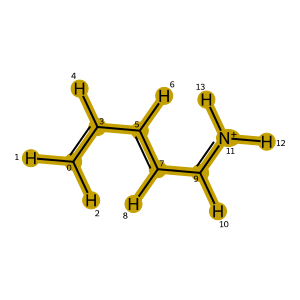

In [3]:
structure_selection_ab.draw('bonds')

By default, the selection extracts the full set of possible features within the first frame of the provided dataset and picks all of the features of your molecule within the selected categories provided as the second argument. 
The default behavior is to only select `bonds` and `atoms`/positions.

If you want to extend the selection to include a type of features you had not initially selected, you can add them:

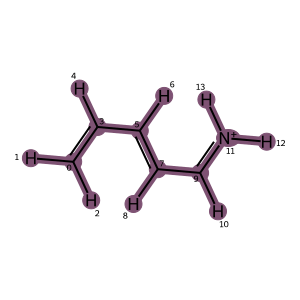

In [4]:
# If you don't specify the category, it will just select all features:
structure_selection_all =  structure_selection_ab.select_all()
structure_selection_all.draw('dihedrals')

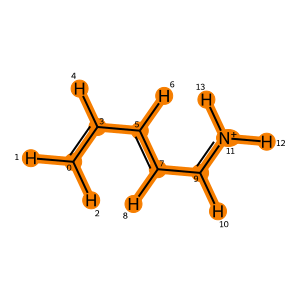

In [5]:
# You can also specifically all pyramidalization centers into the selection
structure_selection_ab_with_p = structure_selection_ab.select_all('pyramids')
# The new selection now includes all pyramids
structure_selection_ab_with_p.draw('pyramids')

Within a selection, you can pick a subset of features using the various `.select_*()` functions.
- `.select_atoms()`, `.select_bonds()`, etc. will only restrict the active selection of the respective features.
- `.select_bats()` will select all features at once. 

You can select features by providing index tuples (or atom indices for positions), e.g.

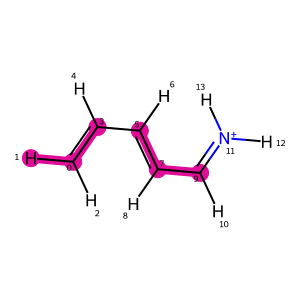

In [6]:
structure_selection_ab.select_angles([(1,0,3), (5,7,9)]).draw('angles')

Or by providing an appropriate SMARTS string of the substructure of your choice:

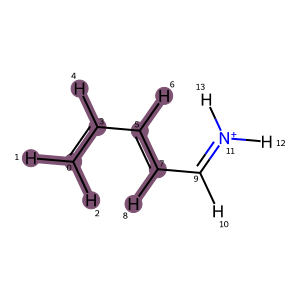

In [7]:
structure_selection_all.select_dihedrals("[#1][#6]=[#6][#1]").draw('dihedrals')

You can provide multiple smarts and indices as a sequence. The resulting selection will be the combined selection according to all individual SMARTS and indices. 

Note, that for the `.select_bats()` function, there are separate arguments for index-based and SMARTS based selection, i.e.:

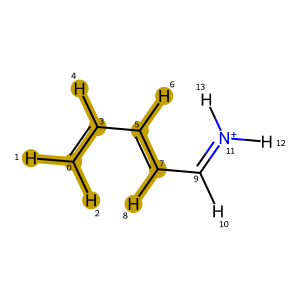

In [8]:
# This selects features based on bats
smarts_bats = structure_selection_all.select_bats(smarts="[#1][#6]=[#6][#1]")
smarts_bats.draw('bonds')

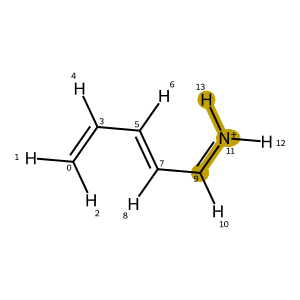

In [9]:
# This selects features based on index tuples
index_bonds = structure_selection_all.select_bats(idxs=[(9,11), (11,13)])
index_bonds.draw('bonds')

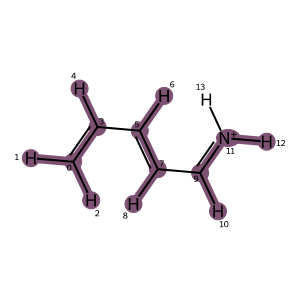

In [10]:
# And you can combine both:
mixed_dihedrals = structure_selection_all.select_bats(smarts="[#1][#6]=[#6][#1]", idxs=[(9,11), (11,13), (10,9,11,12)])
mixed_dihedrals.draw('dihedrals')

Note that the return value of the selection is a new selection with the selection results encoded.
This ensures that an existing selection should not change and that you can use it for multiple sub-selections if you like, 
similar to how we have used `structure_selection_all` as a basis for multiple selections above.
Also, the sub-features of an index-based selection are not included automatically. If you select bond `(9,11)`, the atom positions `9` and `11` are not automatically included as well.

If you want to combine multiple selections, you can do so using set operations and arithmetics:

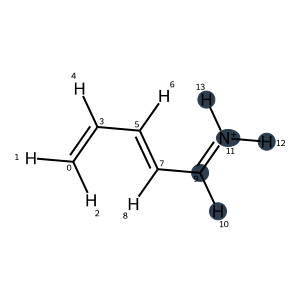

In [11]:
# Remove everying selected in the second selection from the first
(structure_selection_dp-mixed_dihedrals).draw('atoms')

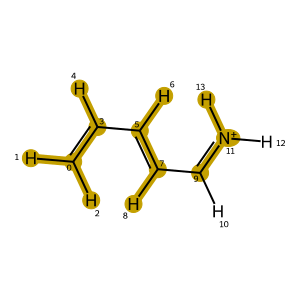

In [12]:
# Remove everying selected in the second selection from the first
(smarts_bats+index_bonds).draw('bonds')

# Or equivalently:
# (smarts_bats|index_bonds).draw('bonds')

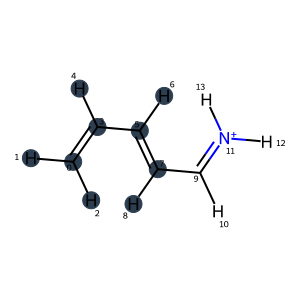

In [13]:
# To get the overlap between selections:
(smarts_bats&mixed_dihedrals).draw('atoms')

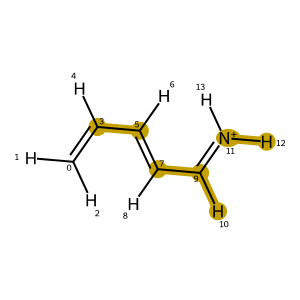

In [14]:
# Or you can get the inverse of a selection:
(~mixed_dihedrals).draw('bonds')

You can use the selection you desired to specify, e.g., which geometric features you would like to be calculated:


In [15]:
from shnitsel.geo.geocalc import get_bats

selected_bats = get_bats(dataset, structure_selection=mixed_dihedrals)
selected_bats

<xarray.DataArray 'BATs(+P)' (descriptor: 45, time: 384)> Size: 69kB
array([[ -4.182025 ,  -4.1810236,  -4.1808057, ...,  -4.0238466,
         -4.0124316,  -4.0008564],
       [ -3.2700472,  -3.2610302,  -3.250624 , ...,  -5.6088247,
         -5.62998  ,  -5.6482987],
       [ -6.2191415,  -6.2317843,  -6.2386346, ...,  -3.6220837,
         -3.583211 ,  -3.5479274],
       ...,
       [175.2993   , 175.82991  , 176.3321   , ..., 177.50423  ,
        176.53049  , 175.52664  ],
       [170.79462  , 169.66696  , 168.67519  , ...,  20.344292 ,
         21.30268  ,  21.893776 ],
       [ 14.961914 ,  14.87782  ,  14.719945 , ...,  12.191796 ,
         12.419447 ,  12.588367 ]], shape=(45, 384), dtype=float32)
Coordinates:
  * descriptor       (descriptor) <U15 3kB 'pos_x(0)' ... 'dih(2,0,3,4)'
  * time             (time) float64 3kB 0.0 0.5 1.0 1.5 ... 190.5 191.0 191.5
    astate           (time) int32 2kB 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1
    sdiag            (time) int32 2kB 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1
    delta_t          float64 8B 0.5
    max_ts           int64 8B 384
    t_max            float64 8B 1e+03
    charge           float64 8B 1.0
    descriptor_tex   (descriptor) <U20 4kB 'x_{0}' ... '\\varphi_{2,0,3,4}'
  * descriptor_type  (descriptor) <U5 900B 'pos' 'pos' 'pos' ... 'dih' 'dih'
  * feature_indices  (descriptor) object 360B 0 1 ... (6, 5, 7, 8) (2, 0, 3, 4)
Attributes:
    unitdim:    length
    long_name:  Bonds, angles, tortions, and pyramidalizations

In [16]:
# Note: This also works if you want to apply the same selection to the entire collection of datasets:
tree_of_bats = get_bats(database, structure_selection=mixed_dihedrals)
tree_of_bats

<class 'shnitsel.data.tree.tree.ShnitselDBRoot[DataArray]'> [{'level': 'ShnitselDBRoot', 'children': '1: {\'I02\': \'ABCMeta(_name=\\\'I02\\\', _dtype=<class \\\'xarray.core.dataarray.DataArray\\\'>, _data=None, _children={\\\'0\\\': ABCMeta(_name=\\\'0\\\', _dtype=<class \\\'xarray.core.dataarray.DataArray\\\'>, _data=<xarray.DataArray \\\'BATs(+P)\\\' (descriptor: 45, time: 384)> Size: 69kB\\narray([[ -4.182025 ,  -4.1810236,  -4.1808057, ...,  -4.0238466,\\n         -4.0124316,  -4.0008564],\\n       [ -3.2700472,  -3.2610302,  -3.250624 , ...,  -5.6088247,\\n         -5.62998  ,  -5.6482987],\\n       [ -6.2191415,  -6.2317843,  -6.2386346, ...,  -3.6220837,\\n         -3.583211 ,  -3.5479274],\\n       ...,\\n       [175.2993   , 175.82991  , 176.3321   , ..., 177.50423  ,\\n        176.53049  , 175.52664  ],\\n       [170.79462  , 169.66696  , 168.67519  , ...,  20.344292 ,\\n         21.30268  ,  21.893776 ],\\n       [ 14.961914 ,  14.87782  ,  14.719945 , ...,  12.191796 ,\\n         12.419447 ,  12.588367 ]], shape=(45, 384), dtype=float32)\\nCoordinates:\\n  * descriptor       (descriptor) <U15 3kB \\\'pos_x(0)\\\' ... \\\'dih(2,0,3,4)\\\'\\n  * time             (time) float64 3kB 0.0 0.5 1.0 1.5 ... 190.5 191.0 191.5\\n    astate           (time) int32 2kB 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1\\n    sdiag            (time) int32 2kB 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1\\n    delta_t          float64 8B 0.5\\n    max_ts           int64 8B 384\\n    t_max            float64 8B 1e+03\\n    charge           float64 8B 1.0\\n    descriptor_tex   (descriptor) <U20 4kB \\\'x_{0}\\\' ... \\\'\\\\\\\\varphi_{2,0,3,4}\\\'\\n  * descriptor_type  (descriptor) <U5 900B \\\'pos\\\' \\\'pos\\\' \\\'pos\\\' ... \\\'dih\\\' \\\'dih\\\'\\n  * feature_indices  (descriptor) object 360B 0 1 ... (6, 5, 7, 8) (2, 0, 3, 4)\\nAttributes:\\n    unitdim:    length\\n    long_name:  Bonds, angles, tortions, and pyramidalizations, _children={}, _attrs={\\\'input_format\\\': \\\'sharc\\\', \\\'t_max\\\': 1000.0, \\\'delta_t\\\': 0.5, \\\'max_ts\\\': 384, \\\'completed\\\': False, \\\'input_type\\\': \\\'dynamic\\\', \\\'input_format_version\\\': \\\'3.0\\\', \\\'num_singlets\\\': 3, \\\'num_doublets\\\': 0, \\\'num_triplets\\\': 0, \\\'has_forces\\\': True, \\\'misc_input_settings\\\': {\\\'input\\\': {\\\'printlevel\\\': \\\'2\\\', \\\'geomfile\\\': \\\'"geom"\\\', \\\'veloc\\\': \\\'external\\\', \\\'velocfile\\\': \\\'"veloc"\\\', \\\'nstates\\\': [3], \\\'actstates\\\': \\\'3\\\', \\\'state\\\': \\\'2 mch\\\', \\\'coeff\\\': \\\'auto\\\', \\\'rngseed\\\': \\\'5199\\\', \\\'ezero\\\': \\\'-248.2781283000\\\', \\\'tmax\\\': \\\'1000.000000\\\', \\\'stepsize\\\': \\\'0.500000\\\', \\\'nsubsteps\\\': \\\'25\\\', \\\'integrator\\\': \\\'fvv\\\', \\\'method\\\': \\\'tsh\\\', \\\'surf\\\': \\\'diagonal\\\', \\\'coupling\\\': \\\'overlap\\\', \\\'nogradcorrect\\\': True, \\\'ekincorrect\\\': \\\'parallel_vel\\\', \\\'reflect_frustrated\\\': \\\'none\\\', \\\'decoherence_scheme\\\': \\\'edc\\\', \\\'decoherence_param\\\': \\\'0.1\\\', \\\'hopping_procedure\\\': \\\'sharc\\\', \\\'grad_all\\\': True, \\\'eselect\\\': \\\'0.001000\\\', \\\'select_directly\\\': True, \\\'nospinorbit\\\': True, \\\'write_grad\\\': True, \\\'write_nacdr\\\': True, \\\'write_overlap\\\': True, \\\'output_format\\\': \\\'ascii\\\', \\\'output_dat_steps\\\': \\\'1\\\'}, \\\'output.dat\\\': {\\\'SHARC_version\\\': \\\'3.0\\\', \\\'method\\\': \\\'0\\\', \\\'integrator\\\': \\\'2\\\', \\\'maxmult\\\': \\\'1\\\', \\\'nstates_m\\\': \\\'3\\\', \\\'natom\\\': \\\'14\\\', \\\'dtstep\\\': \\\'20.670686894780374\\\', \\\'nsteps\\\': \\\'2000\\\', \\\'nsubsteps\\\': \\\'25\\\', \\\'ezero\\\': \\\'-248.27812829999999\\\', \\\'write_overlap\\\': \\\'1\\\', \\\'write_grad\\\': \\\'1\\\', \\\'write_nacdr\\\': \\\'0\\\', \\\'write_property1d\\\': \\\'0\\\', \\\'write_property2d\\\': \\\'0\\\', \\\'n_property1d\\\': \\\'1\\\', \\\'n_property2d\\\': \\\'1\\\', \\\'laser\\\': \\\'0

To simplify the use, you can also opt for default-selections in most methods that accep structure selections like 'bonds'
or provide a textual description of your desired selection:

In [17]:
bonds_only = get_bats(dataset, default_features=['bonds'])
bonds_only

<xarray.DataArray 'BATs(+P)' (descriptor: 13, time: 384)> Size: 20kB
array([[2.0435584, 2.0289316, 2.01827  , ..., 2.1054695, 2.1207495,
        2.1298766],
       [1.9179103, 1.9718978, 2.0327592, ..., 2.0760386, 2.0816746,
        2.0858722],
       [2.2374716, 2.270294 , 2.2873135, ..., 2.286507 , 2.3112004,
        2.3200753],
       ...,
       [2.1280782, 2.166512 , 2.1949997, ..., 2.0632124, 2.1382065,
        2.207789 ],
       [2.4063542, 2.4027956, 2.4020061, ..., 2.4628577, 2.4670072,
        2.4704878],
       [2.6801538, 2.6761117, 2.671661 , ..., 2.823466 , 2.8336463,
        2.8451676]], shape=(13, 384), dtype=float32)
Coordinates:
  * descriptor       (descriptor) <U11 572B 'dist(0,1)' ... 'dist(3,5)'
  * time             (time) float64 3kB 0.0 0.5 1.0 1.5 ... 190.5 191.0 191.5
    astate           (time) int32 2kB 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1
    sdiag            (time) int32 2kB 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1
    delta_t          float64 8B 0.5
    max_ts           int64 8B 384
    t_max            float64 8B 1e+03
    charge           float64 8B 1.0
    descriptor_tex   (descriptor) <U17 884B '|\\vec{r}_{0,1}|' ... '|\\vec{r}...
  * descriptor_type  (descriptor) <U4 208B 'dist' 'dist' ... 'dist' 'dist'
  * feature_indices  (descriptor) object 104B (np.int64(0), np.int64(1)) ... ...
Attributes:
    long_name:  Bonds, angles, tortions, and pyramidalizations
    unitdim:    length
    units:      Bohr

In [18]:
# Or via a SMARTS expression:
smarts_on_the_go = get_bats(dataset, structure_selection=["[#1][#6]=[#6][#1]", '[#7][#1]'])
smarts_on_the_go

<xarray.DataArray 'BATs(+P)' (descriptor: 53, time: 384)> Size: 81kB
array([[ -4.182025 ,  -4.1810236,  -4.1808057, ...,  -4.0238466,
         -4.0124316,  -4.0008564],
       [ -3.2700472,  -3.2610302,  -3.250624 , ...,  -5.6088247,
         -5.62998  ,  -5.6482987],
       [ -6.2191415,  -6.2317843,  -6.2386346, ...,  -3.6220837,
         -3.583211 ,  -3.5479274],
       ...,
       [169.22687  , 167.24527  , 165.33797  , ..., 163.76097  ,
        163.40193  , 163.09521  ],
       [170.79462  , 169.66696  , 168.67519  , ...,  20.344292 ,
         21.30268  ,  21.893776 ],
       [ 14.961914 ,  14.87782  ,  14.719945 , ...,  12.191796 ,
         12.419447 ,  12.588367 ]], shape=(53, 384), dtype=float32)
Coordinates:
  * descriptor       (descriptor) <U12 3kB 'pos_x(0)' ... 'dih(2,0,3,4)'
  * time             (time) float64 3kB 0.0 0.5 1.0 1.5 ... 190.5 191.0 191.5
    astate           (time) int32 2kB 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1
    sdiag            (time) int32 2kB 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1
    delta_t          float64 8B 0.5
    max_ts           int64 8B 384
    t_max            float64 8B 1e+03
    charge           float64 8B 1.0
    descriptor_tex   (descriptor) <U17 4kB 'x_{0}' ... '\\varphi_{2,0,3,4}'
  * descriptor_type  (descriptor) <U5 1kB 'pos' 'pos' 'pos' ... 'dih' 'dih'
  * feature_indices  (descriptor) object 424B 0 1 ... (6, 5, 7, 8) (2, 0, 3, 4)
Attributes:
    unitdim:    length
    long_name:  Bonds, angles, tortions, and pyramidalizations

In [19]:
# Or via a SMARTS expression:
smarts_on_the_go_trajectory_collection = get_bats(database, structure_selection=["[#1][#6]=[#6][#1]", '[#7][#1]'])
smarts_on_the_go_trajectory_collection

<class 'shnitsel.data.tree.tree.ShnitselDBRoot[DataArray]'> [{'level': 'ShnitselDBRoot', 'children': '1: {\'I02\': \'ABCMeta(_name=\\\'I02\\\', _dtype=<class \\\'xarray.core.dataarray.DataArray\\\'>, _data=None, _children={\\\'0\\\': ABCMeta(_name=\\\'0\\\', _dtype=<class \\\'xarray.core.dataarray.DataArray\\\'>, _data=<xarray.DataArray \\\'BATs(+P)\\\' (descriptor: 53, time: 384)> Size: 81kB\\narray([[ -4.182025 ,  -4.1810236,  -4.1808057, ...,  -4.0238466,\\n         -4.0124316,  -4.0008564],\\n       [ -3.2700472,  -3.2610302,  -3.250624 , ...,  -5.6088247,\\n         -5.62998  ,  -5.6482987],\\n       [ -6.2191415,  -6.2317843,  -6.2386346, ...,  -3.6220837,\\n         -3.583211 ,  -3.5479274],\\n       ...,\\n       [169.22687  , 167.24527  , 165.33797  , ..., 163.76097  ,\\n        163.40193  , 163.09521  ],\\n       [170.79462  , 169.66696  , 168.67519  , ...,  20.344292 ,\\n         21.30268  ,  21.893776 ],\\n       [ 14.961914 ,  14.87782  ,  14.719945 , ...,  12.191796 ,\\n         12.419447 ,  12.588367 ]], shape=(53, 384), dtype=float32)\\nCoordinates:\\n  * descriptor       (descriptor) <U12 3kB \\\'pos_x(0)\\\' ... \\\'dih(2,0,3,4)\\\'\\n  * time             (time) float64 3kB 0.0 0.5 1.0 1.5 ... 190.5 191.0 191.5\\n    astate           (time) int32 2kB 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1\\n    sdiag            (time) int32 2kB 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1\\n    delta_t          float64 8B 0.5\\n    max_ts           int64 8B 384\\n    t_max            float64 8B 1e+03\\n    charge           float64 8B 1.0\\n    descriptor_tex   (descriptor) <U17 4kB \\\'x_{0}\\\' ... \\\'\\\\\\\\varphi_{2,0,3,4}\\\'\\n  * descriptor_type  (descriptor) <U5 1kB \\\'pos\\\' \\\'pos\\\' \\\'pos\\\' ... \\\'dih\\\' \\\'dih\\\'\\n  * feature_indices  (descriptor) object 424B 0 1 ... (6, 5, 7, 8) (2, 0, 3, 4)\\nAttributes:\\n    unitdim:    length\\n    long_name:  Bonds, angles, tortions, and pyramidalizations, _children={}, _attrs={\\\'input_format\\\': \\\'sharc\\\', \\\'t_max\\\': 1000.0, \\\'delta_t\\\': 0.5, \\\'max_ts\\\': 384, \\\'completed\\\': False, \\\'input_type\\\': \\\'dynamic\\\', \\\'input_format_version\\\': \\\'3.0\\\', \\\'num_singlets\\\': 3, \\\'num_doublets\\\': 0, \\\'num_triplets\\\': 0, \\\'has_forces\\\': True, \\\'misc_input_settings\\\': {\\\'input\\\': {\\\'printlevel\\\': \\\'2\\\', \\\'geomfile\\\': \\\'"geom"\\\', \\\'veloc\\\': \\\'external\\\', \\\'velocfile\\\': \\\'"veloc"\\\', \\\'nstates\\\': [3], \\\'actstates\\\': \\\'3\\\', \\\'state\\\': \\\'2 mch\\\', \\\'coeff\\\': \\\'auto\\\', \\\'rngseed\\\': \\\'5199\\\', \\\'ezero\\\': \\\'-248.2781283000\\\', \\\'tmax\\\': \\\'1000.000000\\\', \\\'stepsize\\\': \\\'0.500000\\\', \\\'nsubsteps\\\': \\\'25\\\', \\\'integrator\\\': \\\'fvv\\\', \\\'method\\\': \\\'tsh\\\', \\\'surf\\\': \\\'diagonal\\\', \\\'coupling\\\': \\\'overlap\\\', \\\'nogradcorrect\\\': True, \\\'ekincorrect\\\': \\\'parallel_vel\\\', \\\'reflect_frustrated\\\': \\\'none\\\', \\\'decoherence_scheme\\\': \\\'edc\\\', \\\'decoherence_param\\\': \\\'0.1\\\', \\\'hopping_procedure\\\': \\\'sharc\\\', \\\'grad_all\\\': True, \\\'eselect\\\': \\\'0.001000\\\', \\\'select_directly\\\': True, \\\'nospinorbit\\\': True, \\\'write_grad\\\': True, \\\'write_nacdr\\\': True, \\\'write_overlap\\\': True, \\\'output_format\\\': \\\'ascii\\\', \\\'output_dat_steps\\\': \\\'1\\\'}, \\\'output.dat\\\': {\\\'SHARC_version\\\': \\\'3.0\\\', \\\'method\\\': \\\'0\\\', \\\'integrator\\\': \\\'2\\\', \\\'maxmult\\\': \\\'1\\\', \\\'nstates_m\\\': \\\'3\\\', \\\'natom\\\': \\\'14\\\', \\\'dtstep\\\': \\\'20.670686894780374\\\', \\\'nsteps\\\': \\\'2000\\\', \\\'nsubsteps\\\': \\\'25\\\', \\\'ezero\\\': \\\'-248.27812829999999\\\', \\\'write_overlap\\\': \\\'1\\\', \\\'write_grad\\\': \\\'1\\\', \\\'write_nacdr\\\': \\\'0\\\', \\\'write_property1d\\\': \\\'0\\\', \\\'write_property2d\\\': \\\'0\\\', \\\'n_property1d\\\': \\\'1\\\', \\\'n_property2d\\\': \\\'1\\\', \\\'laser\\\': \\\'0\